In [99]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2010, 1, 10)
#end = datetime.datetime.now()
end = datetime.datetime(2017, 1, 11)
df = web.DataReader("AAPL", 'yahoo', start, end)
#df.head()
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,116.860001,115.809998,115.919998,116.610001,22193600.0,111.727715
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,112.973305
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,114.008080
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,114.123047
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,114.736275


In [100]:
# calculate Rolling Mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

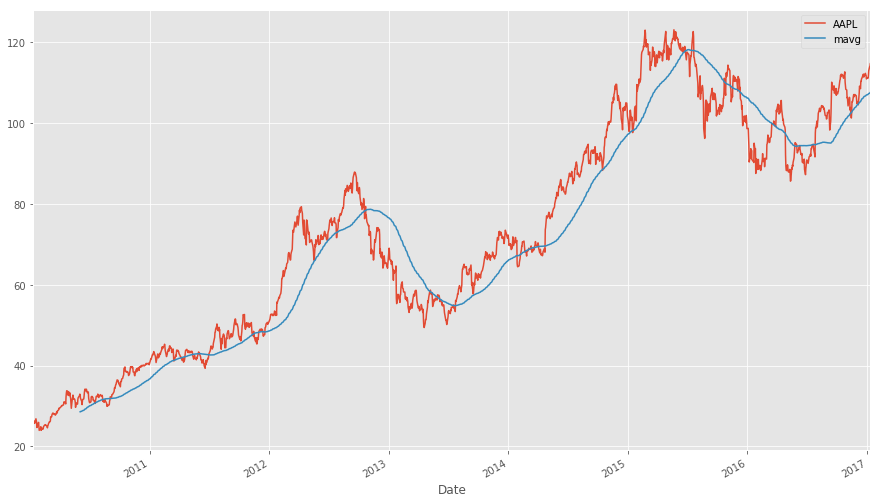

In [101]:
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
#mpl.rc('figure', figsize=(8, 7))
mpl.rc('figure', figsize=(15, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()
plt.show()

In [102]:
# return deviation
rets = close_px / close_px.shift(1) - 1
rets.head()

Date
2010-01-11         NaN
2010-01-12   -0.011375
2010-01-13    0.014105
2010-01-14   -0.005791
2010-01-15   -0.016712
Name: Adj Close, dtype: float64

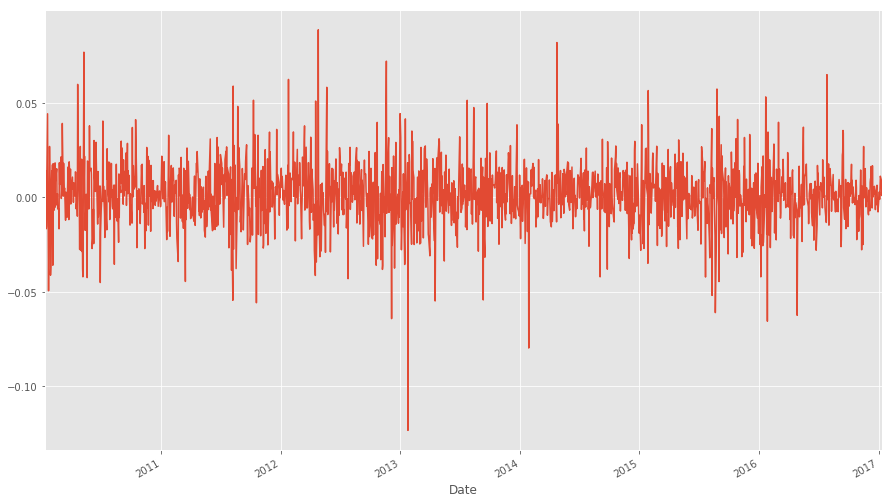

In [103]:
rets.plot(label='return')
plt.show()

In [104]:
# analysing competitor stocks
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2017-01-05,111.727715,27.911093,794.020020,150.013260,59.230362
2017-01-06,112.973305,27.990791,806.150024,150.751312,59.743763
2017-01-09,114.008080,27.857965,806.650024,149.079559,59.553616
2017-01-10,114.123047,27.778269,804.789978,147.185501,59.534603
2017-01-11,114.736275,27.866817,807.909973,149.168472,60.076519


In [105]:
# correlation analysis
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.383496,0.411252,0.383537,0.393108
GE,0.383496,1.000000,0.427248,0.538563,0.478097
GOOG,0.411252,0.427248,1.000000,0.402586,0.471742
IBM,0.383537,0.538563,0.402586,1.000000,0.496384
MSFT,0.393108,0.478097,0.471742,0.496384,1.000000


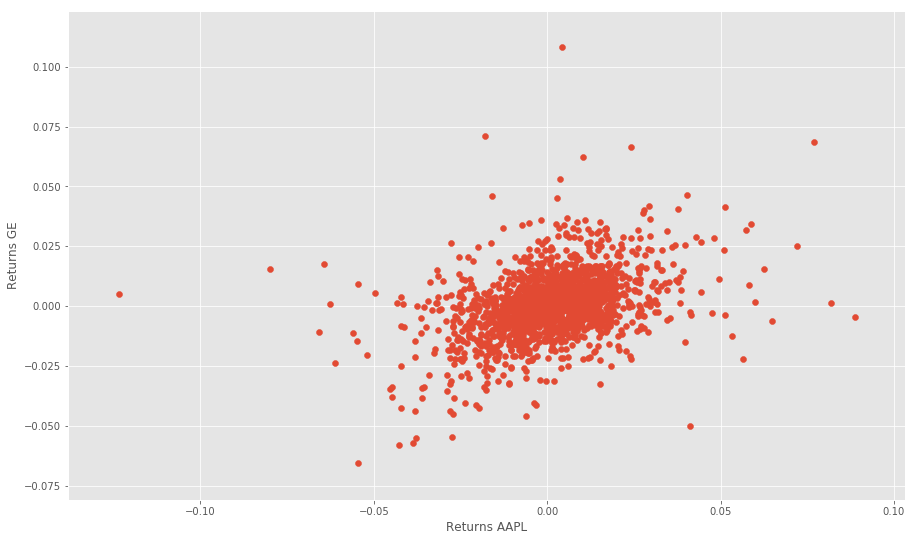

In [106]:
# apple and GE return distribution
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')
plt.show()

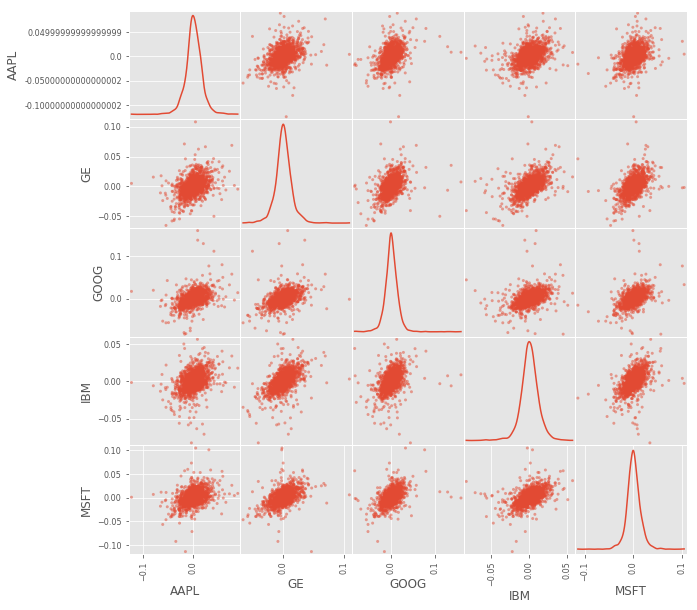

In [107]:
# Kernel Density Estimate (KDE)
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));
plt.show()

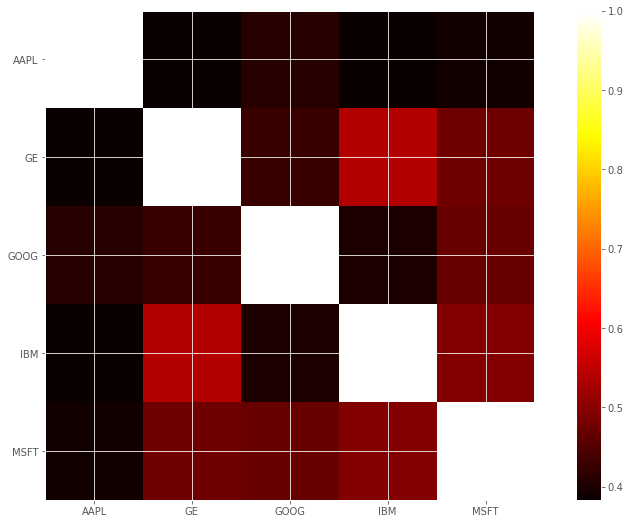

In [108]:
# heat map
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);
plt.show()

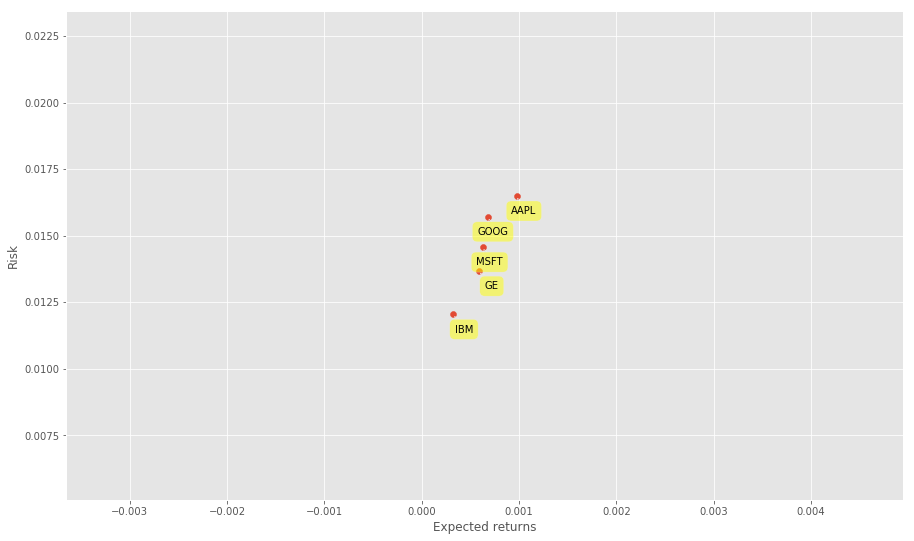

In [109]:
# stock returns rate and risk
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

In [110]:
# feature engineering
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-11,26.195114,115557400.0,2.165531,-1.264095
2010-01-12,25.897146,148614900.0,1.612746,-0.702707
2010-01-13,26.262434,151473000.0,3.242343,1.337373
2010-01-14,26.110340,108223500.0,0.687577,-0.323641
2010-01-15,25.673977,148516900.0,2.782498,-2.370452


In [111]:
import math
import numpy as np
from sklearn import preprocessing, cross_validation, svm

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
print(dfreg.shape)
#print(dfreg)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
#print(X)
print('Dimension of y',y.shape)

(1764, 4)
Dimension of X (1746, 4)
Dimension of y (1746,)


In [112]:
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [113]:
# model generation
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [114]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [115]:
# evaluation
confidencereg = clfreg.score(X_test, y_test)
print('The linear regression confidence is {}'.format(confidencereg))

confidencepoly2 = clfpoly2.score(X_test,y_test)
print('The quadratic regression 2 confidence is {}'.format(confidencepoly2))

confidencepoly3 = clfpoly3.score(X_test,y_test)
print('The quadratic regression 3 confidence is {}'.format(confidencepoly3))

confidenceknn = clfknn.score(X_test, y_test)
print('The knn regression confidence is {}'.format(confidenceknn))

# top 3 models are
# 1. linear regression: 0.9715671136865407
# 2. quadratic regression 3: 0.9536641707905672
# 3. quadratic regression 2: 0.9493183299155221
# *Score numbers above are changing everytime you run this program. This is the numbers when I ran.

The linear regression confidence is 0.9660138877745087
The quadratic regression 2 confidence is 0.9650307264026774
The quadratic regression 3 confidence is 0.9665018124821944
The knn regression confidence is 0.9467461563686416


2017-01-11 00:00:00


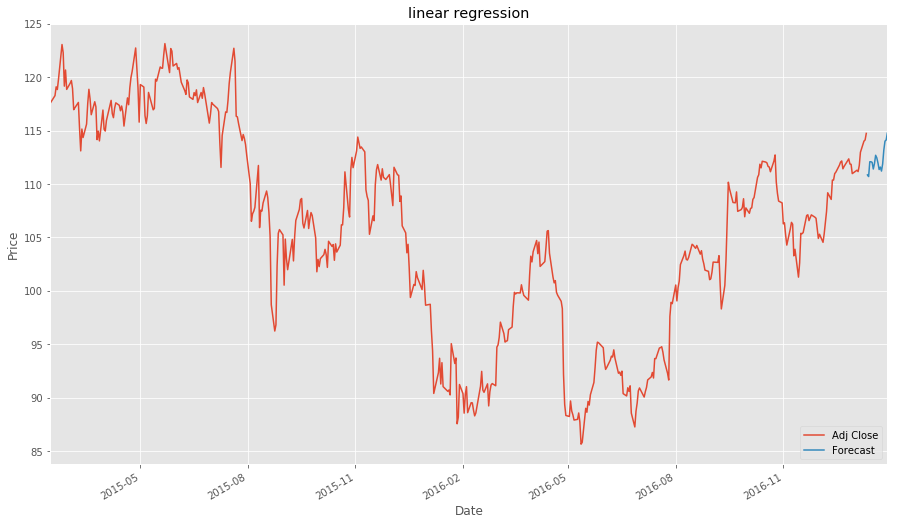

2017-01-11 00:00:00


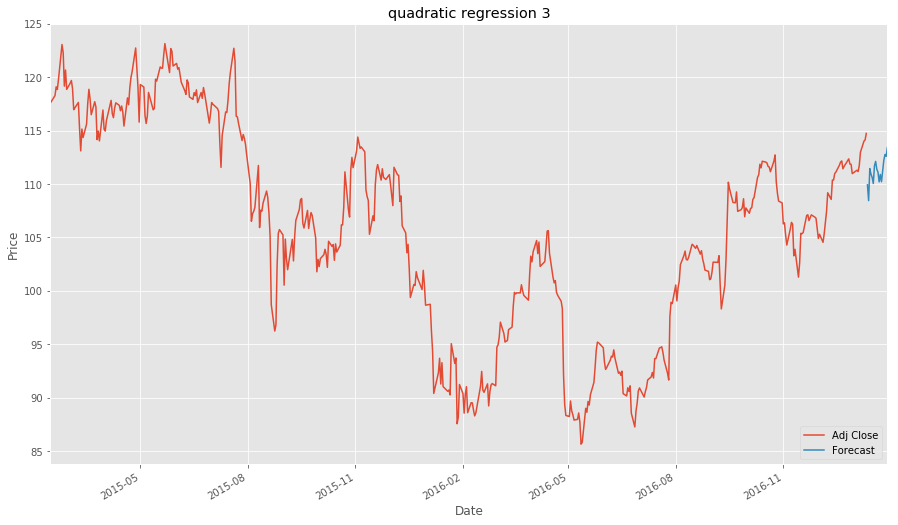

2017-01-11 00:00:00


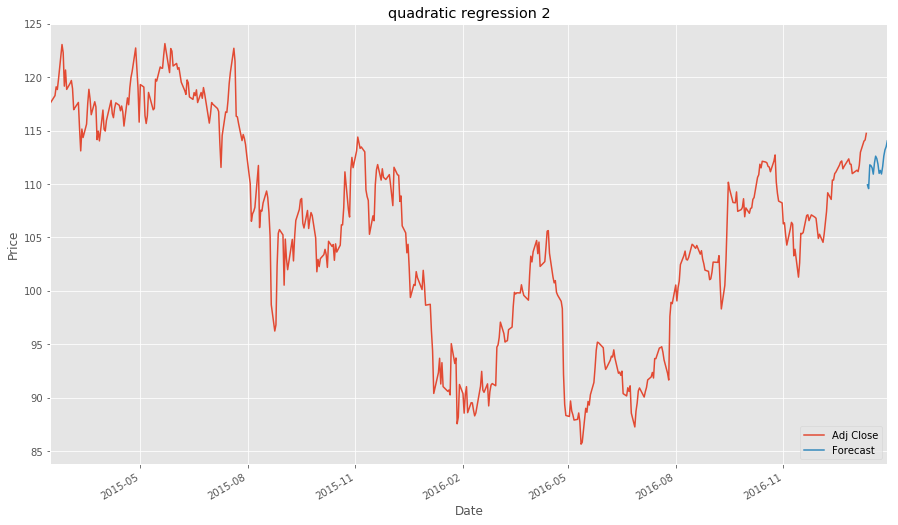

In [116]:
# stock forecast
forecast_set = {
    "linear regression": clfreg.predict(X_lately),
    "quadratic regression 3": clfpoly3.predict(X_lately),
    "quadratic regression 2": clfpoly2.predict(X_lately)
}
#print(forecast_set)

# get last_date
last_date = dfreg.iloc[-1].name

for k, v in forecast_set.items():
    dfreg['Forecast'] = np.nan
    #print(dfreg['Forecast'])
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)
    print(last_date)
    #for i in forecast_set:
    for i in v:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.title(k)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()